In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from venn_abers import VennAbersCalibrator
from mapie.metrics.calibration import expected_calibration_error

In [4]:
def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return expected_calibration_error(y, p, num_bins=n_bins, split_strategy="quantile"), pt, pp

# def ece_quantile(y, p, n_bins=10):
#     return expected_calibration_error(y, p, num_bins=n_bins, split_strategy="quantile")


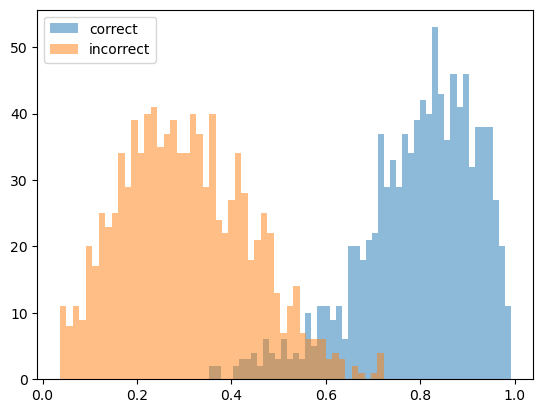

In [19]:
rng = np.random.default_rng(42)
# # for class 0
# plt.hist(rng.beta(2, 8, size=1000), bins=50, alpha=0.5, label='correct')
# plt.hist(rng.beta(7, 3, size=1000), bins=50, alpha=0.5, label='incorrect')
# plt.show()

# for class 1
plt.hist(rng.beta(8, 2, size=1000), bins=50, alpha=0.5, label='correct')
plt.hist(rng.beta(3, 7, size=1000), bins=50, alpha=0.5, label='incorrect')
plt.legend()
plt.show()

In [20]:
def run_simulation(counts, title="Simulation"):
    rng = np.random.default_rng(42)


    # # Class 0: mixture of two Betas(2,5) and (1,8)
    # probs_0 = 0.7 * rng.beta(2, 8, size=counts[0]) + 0.3 * rng.beta(1, 8, size=counts[0]) * rng.choice([-1, 1], size=counts[0])
    # probs_0 = np.clip(probs_0, 0, 1)
    
    # rng = np.random.default_rng(0)
    # # Class 1: mixture of two Betas(10,5) and (1,8)
    # probs_1 = 0.7 * rng.beta(8, 2, size=counts[1]) + 0.3 * rng.beta(1, 8, size=counts[1]) * rng.choice([-1, 1], size=counts[1])
    # probs_1 = np.clip(probs_1, 0, 1)

    # Calculate the number of samples for each component
    n0_correct = int(0.7 * counts[0])  # 70% of Class 0 are correct predictions
    n0_error = counts[0] - n0_correct   # 30% of Class 0 are overconfident errors

    n1_correct = int(0.7 * counts[1])  # 70% of Class 1 are correct predictions
    n1_error = counts[1] - n1_correct   # 30% of Class 1 are underconfident errors

    # Class 0: mixture of two Betas(2,5) and (1,8)
    # probs_0 = 0.7 * rng.beta(2, 8, size=counts[0]) + 0.3 * rng.beta(7, 3, size=counts[0])
    probs_0 = np.concatenate([
        rng.beta(2, 8, size=n0_correct),   # Correct predictions (low scores)
        rng.beta(7, 3, size=n0_error)    # Overconfident errors (high scores)
    ])
    probs_0 = np.clip(probs_0, 0, 1)
    # print(probs_0.shape)
    
    rng = np.random.default_rng(0)
    # Class 1: mixture of two Betas(10,5) and (1,8)
    # probs_1 = 0.7 * rng.beta(8, 2, size=counts[1]) + 0.3 * rng.beta(3, 7, size=counts[1])
    probs_1 = np.concatenate([
        rng.beta(8, 2, size=n1_correct),   # Correct predictions (high scores)
        rng.beta(3, 7, size=n1_error)    # Underconfident errors (low scores)
    ])
    probs_1 = np.clip(probs_1, 0, 1)
    # print(probs_1.shape)

    df_sim = pd.DataFrame({
        "y": np.concatenate([np.zeros(n0_correct + n0_error, int), np.ones(n1_correct + n1_error, int)]),
        "proba": np.concatenate([probs_0, probs_1])
    }).sample(frac=1, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(8,5))
    sns.histplot(df_sim[df_sim["y"]==0]["proba"], bins=30, color="blue", label="Class 0", stat="density", alpha=0.5)
    sns.histplot(df_sim[df_sim["y"]==1]["proba"], bins=30, color="red", label="Class 1", stat="density", alpha=0.5)

    sns.kdeplot(df_sim[df_sim["y"]==0]["proba"], color="blue", lw=2)
    sns.kdeplot(df_sim[df_sim["y"]==1]["proba"], color="red", lw=2)

    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.title(f"Simulated Probabilities by Class {title}")
    plt.legend()
    plt.show()

    # print(f"\n=== {title} ===")
    # print(df_sim.groupby("y")["proba"].describe())

    # ---- Calibration split ----
    X_cal, X_test, y_cal, y_test = train_test_split(
        df_sim[["proba"]].values, df_sim["y"].values,
        test_size=0.3, stratify=df_sim["y"].values, random_state=42
    )
    s_cal, s_test = X_cal.ravel(), X_test.ravel()

    # ---- Platt ----
    p_platt_test, _ = platt_fit_predict(s_cal, y_cal, s_test)
    p_platt_cal, _  = platt_fit_predict(s_cal, y_cal, s_cal)

    # ---- Isotonic ----
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(s_cal, y_cal)
    p_iso_test, p_iso_cal = iso.predict(s_test), iso.predict(s_cal)

    # ---- Venn-Abers ----
    p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
    p_test_2d = np.column_stack([1 - s_test, s_test])
    va = VennAbersCalibrator()
    p_va_test = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                 p_test=p_test_2d, p0_p1_output=False)[:,1]
    p_va_cal = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                p_test=p_cal_2d, p0_p1_output=False)[:,1]

    # ---- Results ----
    methods_test = {
        "Raw": s_test,
        "Platt": p_platt_test,
        "Isotonic": p_iso_test,
        "Venn-Abers-IVAP": p_va_test,
    }
    methods_cal = {
        "Raw": s_cal,
        "Platt": p_platt_cal,
        "Isotonic": p_iso_cal,
        "Venn-Abers-IVAP": p_va_cal,
    }

    def evaluate(methods, y, setname):
        rows = []
        for name, p in methods.items():
            ece, _, _ = ece_quantile(y, p, n_bins=10)
            rows.append({
                "Method": name,
                "LogLoss": log_loss(y, p),
                "Brier": brier_score_loss(y, p),
                "ROC_AUC": roc_auc_score(y, p),
                "ECE": ece,
            })
        df = pd.DataFrame(rows).set_index("Method").round(4)
        print(f"\nCalibration Metrics ({setname} set):")
        display(df)

    # --- Metrics ---
    evaluate(methods_cal,  y_cal,  "Calibration")
    evaluate(methods_test, y_test, "Test")

    # --- Calibration curves: CAL set ---
    plt.figure(figsize=(6,6))
    max_pp = []
    max_pt = []
    for name, p in methods_cal.items():
        _, pt, pp = ece_quantile(y_cal, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
        max_pp.append(max(pp))
        max_pt.append(max(pt))

    plt.plot([0,max(max(max_pp), max(max_pt))],[0,max(max(max_pp), max(max_pt))],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Calibration set) - {title}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Calibration curves: TEST set ---
    plt.figure(figsize=(6,6))
    max_pp = []
    max_pt = []
    for name, p in methods_test.items():
        _, pt, pp = ece_quantile(y_test, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
        max_pp.append(max(pp))
        max_pt.append(max(pt))

    plt.plot([0,max(max(max_pp), max(max_pt))],[0,max(max(max_pp), max(max_pt))],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Test set) - {title}")
    plt.legend(); plt.grid(True); plt.show()


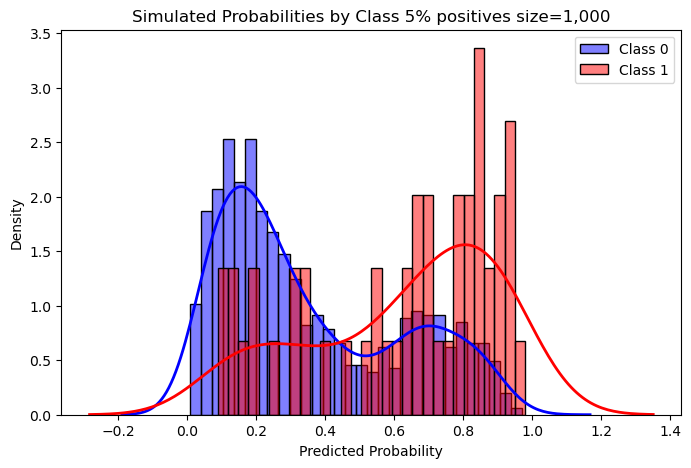


Calibration Metrics (Calibration set):


c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5671,0.1931,0.7723,0.3190
Platt,0.1725,0.0441,0.7723,0.0143
Isotonic,0.1633,0.0424,0.8007,0.0000
Venn-Abers-IVAP,0.1692,0.0430,0.7928,0.0129



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5587,0.1897,0.7460,0.3086
Platt,0.1747,0.0433,0.7460,0.0146
Isotonic,0.2790,0.0429,0.7237,0.0152
Venn-Abers-IVAP,0.1758,0.0433,0.7387,0.0148


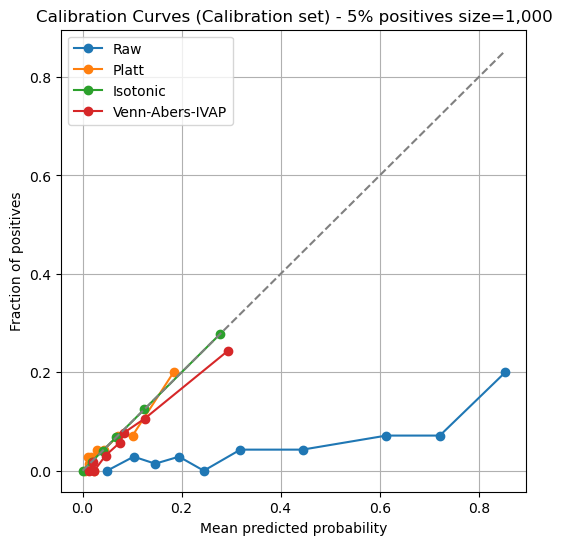

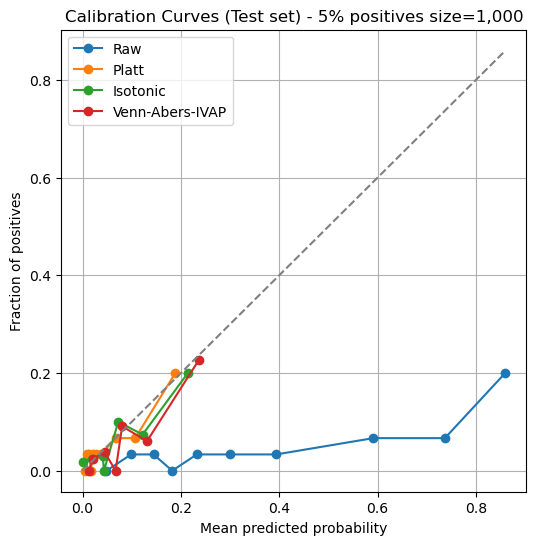

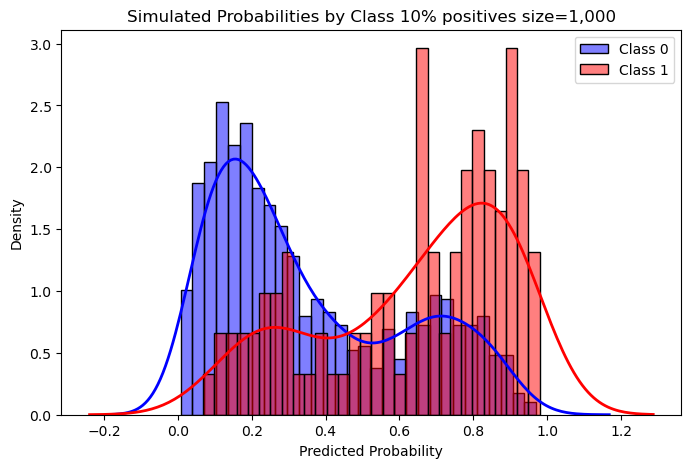


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5390,0.1830,0.7873,0.2715
Platt,0.2713,0.0777,0.7873,0.0100
Isotonic,0.2598,0.0746,0.8026,0.0000
Venn-Abers-IVAP,0.2654,0.0754,0.7990,0.0140



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.6085,0.2065,0.7826,0.3024
Platt,0.2748,0.0789,0.7826,0.0421
Isotonic,0.2829,0.0816,0.7894,0.0501
Venn-Abers-IVAP,0.2813,0.0806,0.7867,0.0475


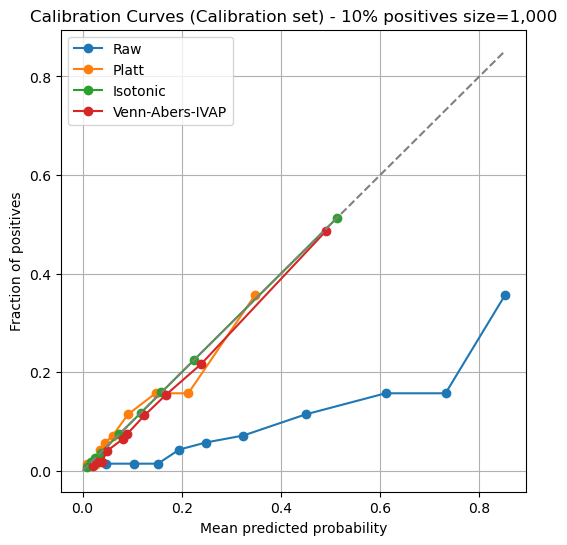

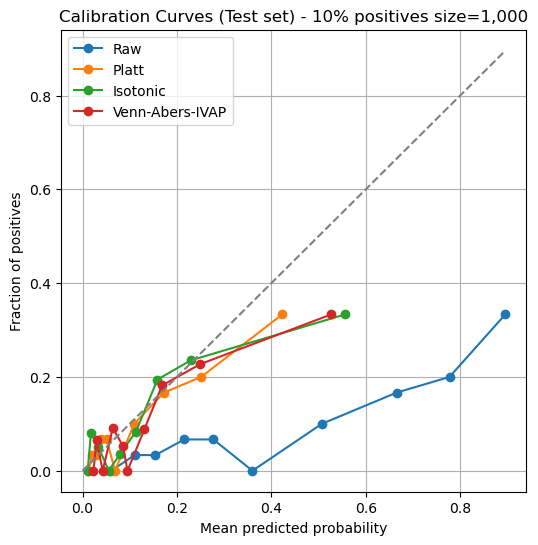

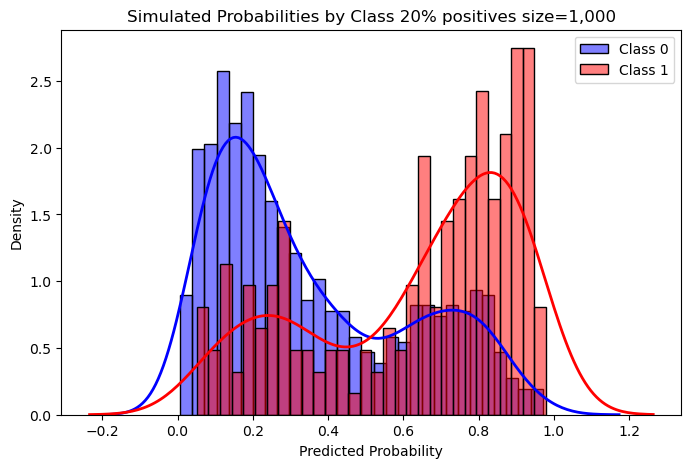


Calibration Metrics (Calibration set):


c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5775,0.1958,0.7514,0.1993
Platt,0.4301,0.1350,0.7514,0.0364
Isotonic,0.4112,0.1291,0.7687,0.0000
Venn-Abers-IVAP,0.4156,0.1298,0.7662,0.0090



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5661,0.1901,0.8136,0.2316
Platt,0.3979,0.1244,0.8136,0.0521
Isotonic,0.4012,0.1250,0.7986,0.0355
Venn-Abers-IVAP,0.4052,0.1256,0.8026,0.0522


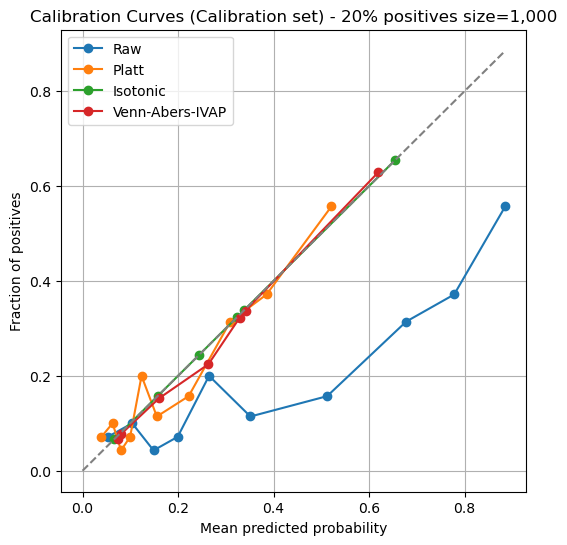

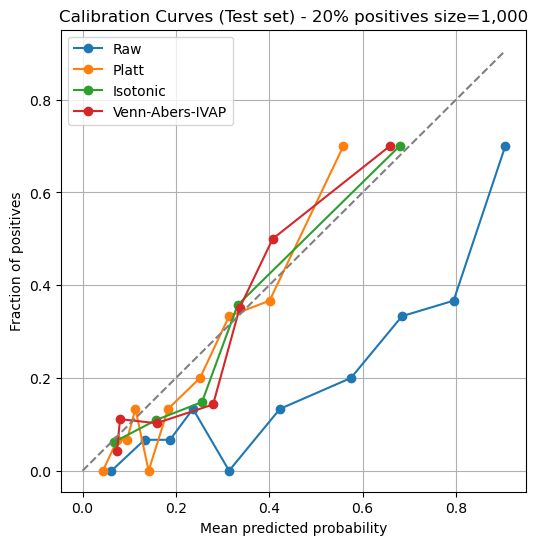

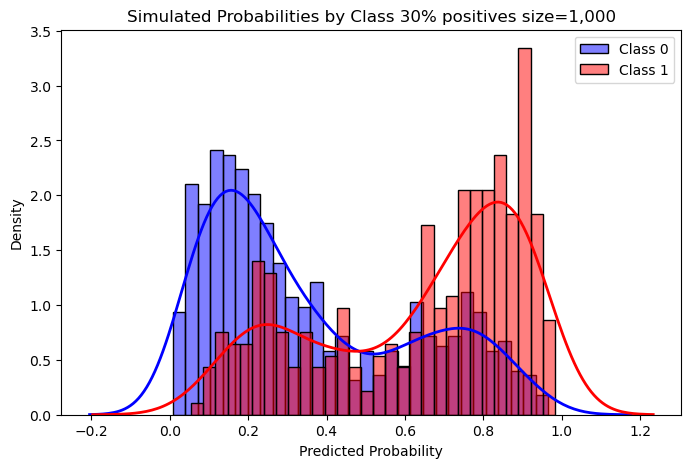


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5746,0.1959,0.7765,0.1395
Platt,0.5037,0.1667,0.7765,0.0261
Isotonic,0.4882,0.1620,0.7861,0.0000
Venn-Abers-IVAP,0.4937,0.1630,0.7847,0.0132



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5735,0.1936,0.7879,0.1396
Platt,0.4968,0.1646,0.7879,0.0367
Isotonic,0.7203,0.1661,0.7853,0.0317
Venn-Abers-IVAP,0.4949,0.1638,0.7847,0.0248


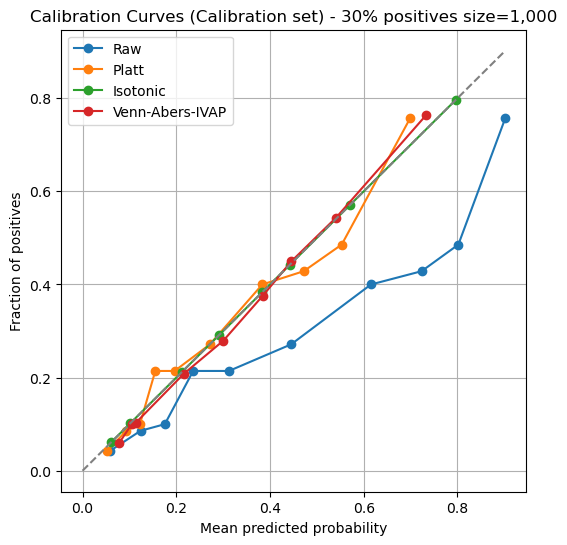

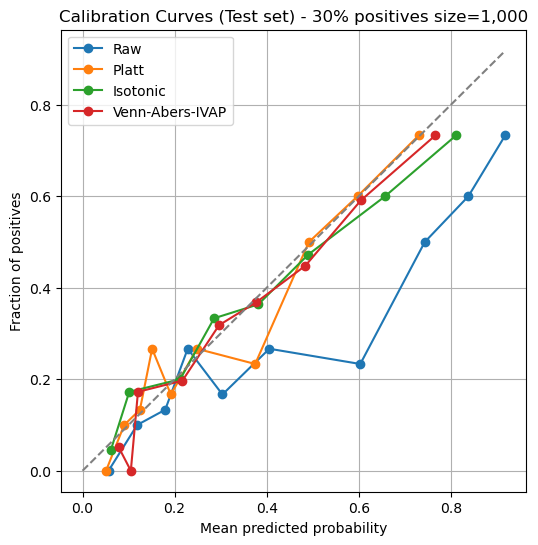

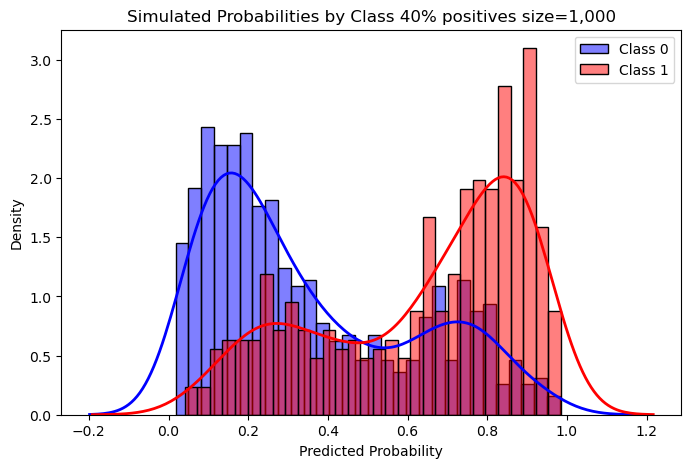


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5708,0.1918,0.7836,0.0769
Platt,0.5474,0.1839,0.7836,0.0228
Isotonic,0.5323,0.1789,0.7931,0.0000
Venn-Abers-IVAP,0.5368,0.1798,0.7918,0.0139



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5548,0.1876,0.8006,0.0832
Platt,0.5326,0.1784,0.8006,0.0594
Isotonic,0.6365,0.1768,0.8016,0.0701
Venn-Abers-IVAP,0.5294,0.1771,0.8018,0.0664


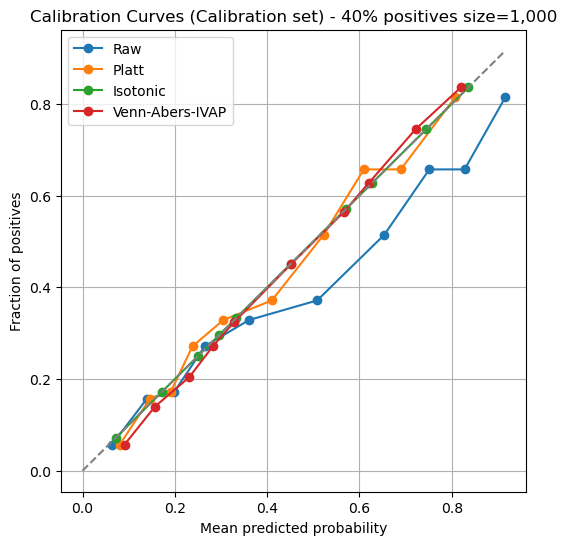

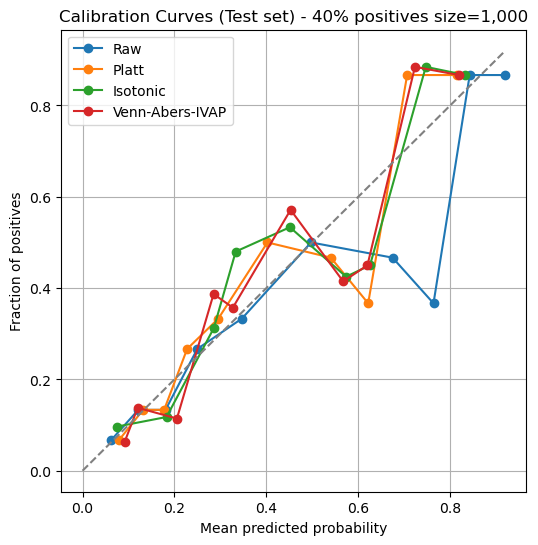

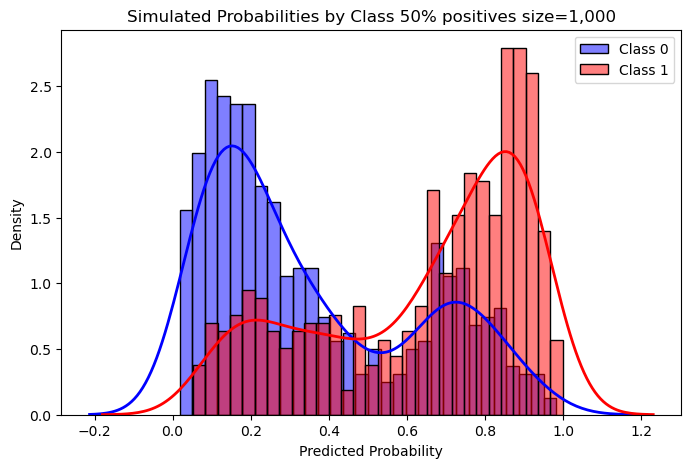


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5811,0.1958,0.7792,0.0687
Platt,0.5660,0.1914,0.7792,0.0324
Isotonic,0.5489,0.1859,0.7887,0.0000
Venn-Abers-IVAP,0.5537,0.1869,0.7874,0.0135



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5814,0.1987,0.7794,0.0898
Platt,0.5656,0.1930,0.7794,0.0668
Isotonic,0.5629,0.1926,0.7774,0.0726
Venn-Abers-IVAP,0.5625,0.1915,0.7795,0.0500


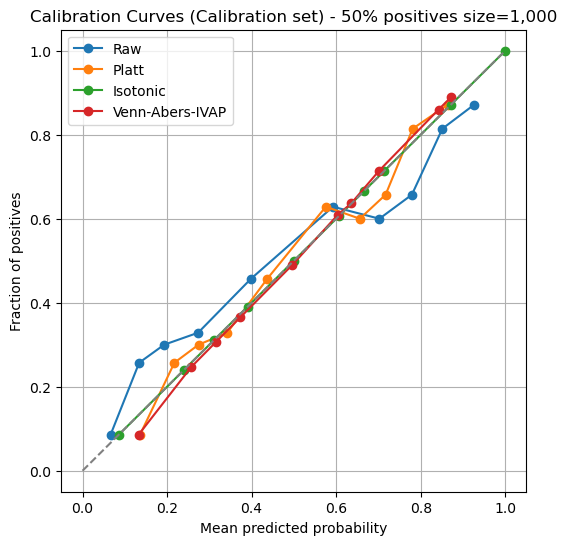

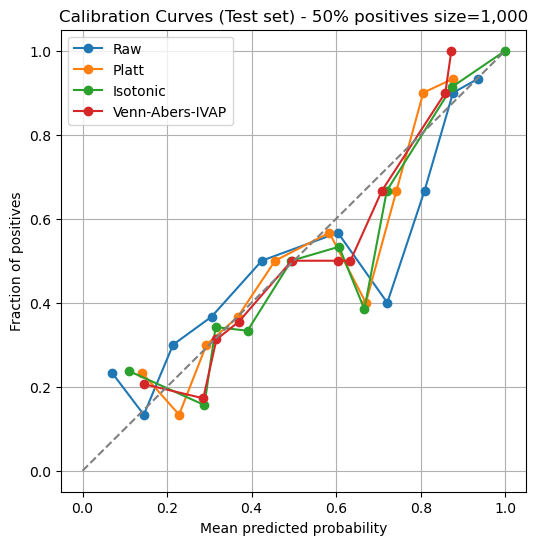

In [21]:
# Size of dataset: 1,000 samples
run_simulation({0: 950, 1: 50}, title="5% positives size=1,000")

run_simulation({0: 900, 1: 100}, title="10% positives size=1,000")

run_simulation({0: 800, 1: 200}, title="20% positives size=1,000")

run_simulation({0: 700, 1: 300}, title="30% positives size=1,000")

run_simulation({0: 600, 1: 400}, title="40% positives size=1,000")

run_simulation({0: 500, 1: 500}, title="50% positives size=1,000")

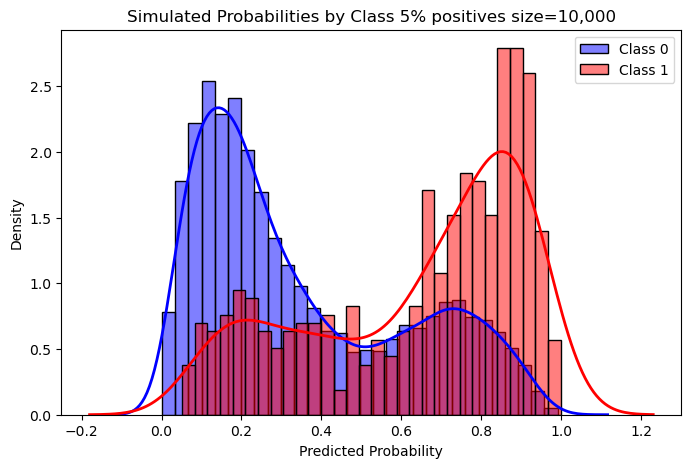


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5601,0.1885,0.7928,0.3130
Platt,0.1680,0.0432,0.7928,0.0025
Isotonic,0.1654,0.0427,0.7995,0.0000
Venn-Abers-IVAP,0.1662,0.0428,0.7984,0.0027



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5621,0.1909,0.7591,0.3119
Platt,0.1759,0.0444,0.7591,0.0084
Isotonic,0.1757,0.0445,0.7564,0.0080
Venn-Abers-IVAP,0.1758,0.0445,0.7571,0.0080


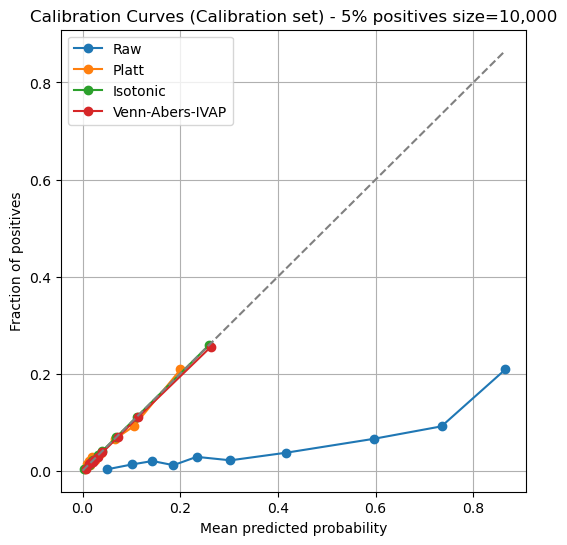

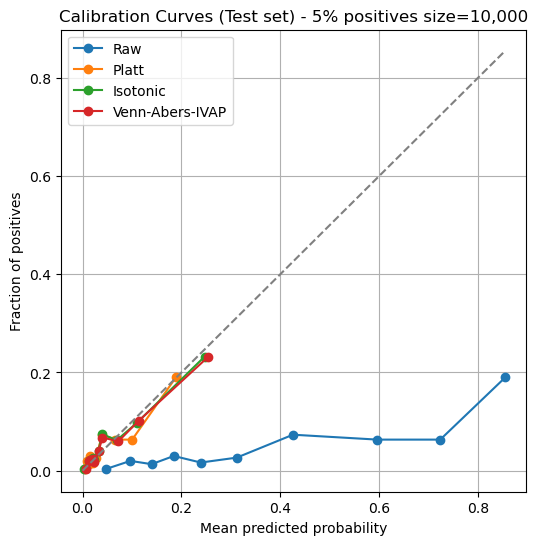

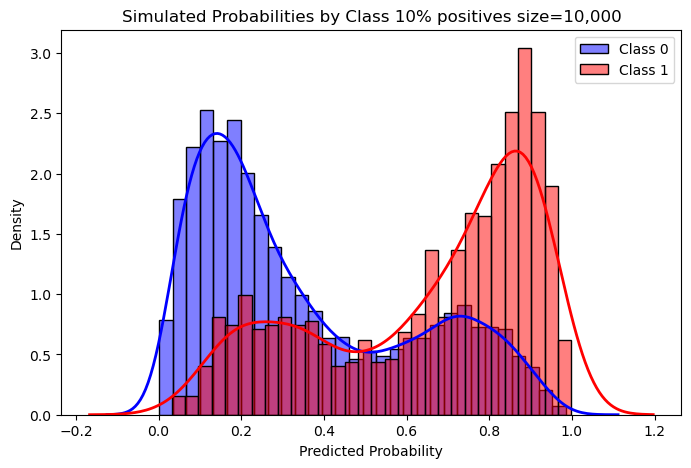


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5566,0.1879,0.8012,0.2788
Platt,0.2658,0.0762,0.8012,0.0143
Isotonic,0.2613,0.0750,0.8059,0.0000
Venn-Abers-IVAP,0.2621,0.0751,0.8054,0.0023



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5614,0.1896,0.7830,0.2770
Platt,0.2744,0.0785,0.7830,0.0126
Isotonic,0.2744,0.0787,0.7823,0.0109
Venn-Abers-IVAP,0.2743,0.0787,0.7821,0.0093


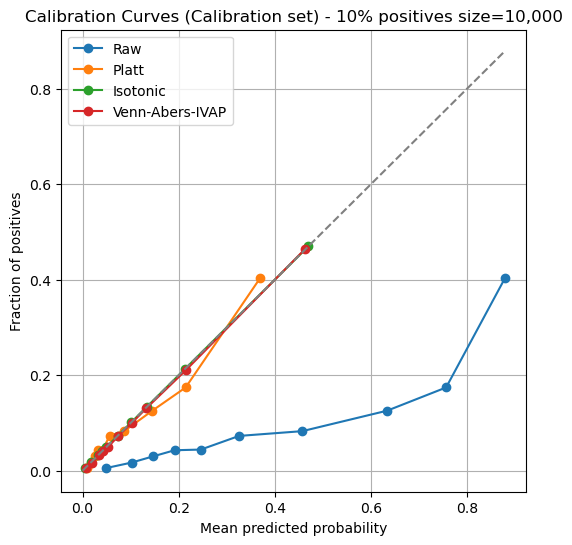

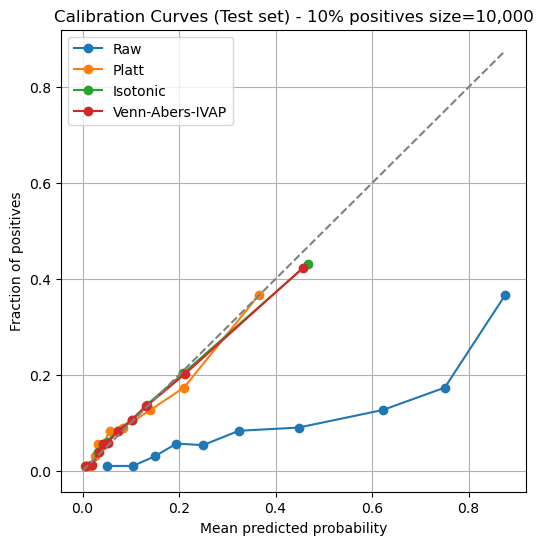

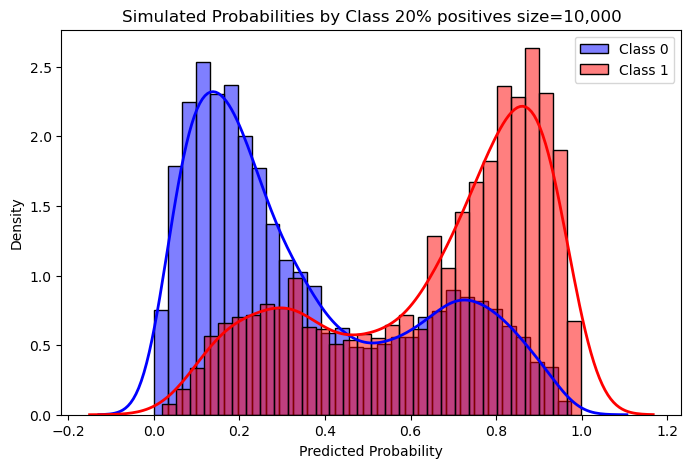


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5571,0.1880,0.7923,0.2063
Platt,0.4070,0.1288,0.7923,0.0153
Isotonic,0.4014,0.1270,0.7959,0.0000
Venn-Abers-IVAP,0.4023,0.1272,0.7956,0.0030



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5602,0.1896,0.8099,0.2180
Platt,0.3946,0.1245,0.8099,0.0213
Isotonic,0.3948,0.1247,0.8085,0.0130
Venn-Abers-IVAP,0.3949,0.1245,0.8087,0.0149


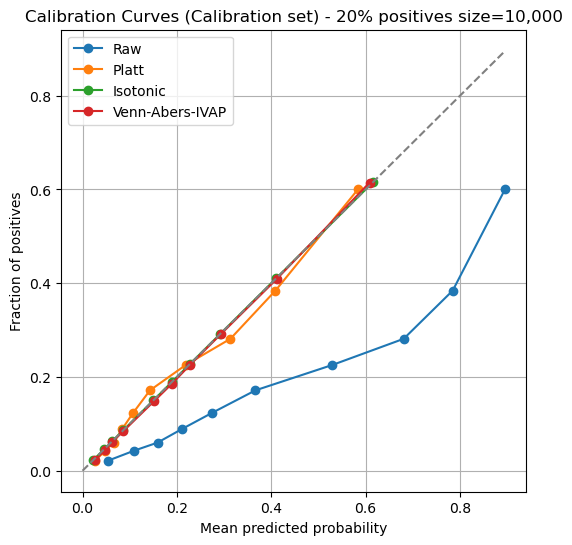

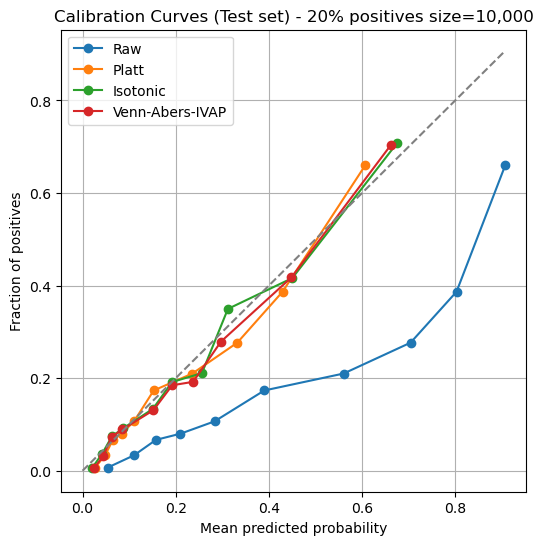

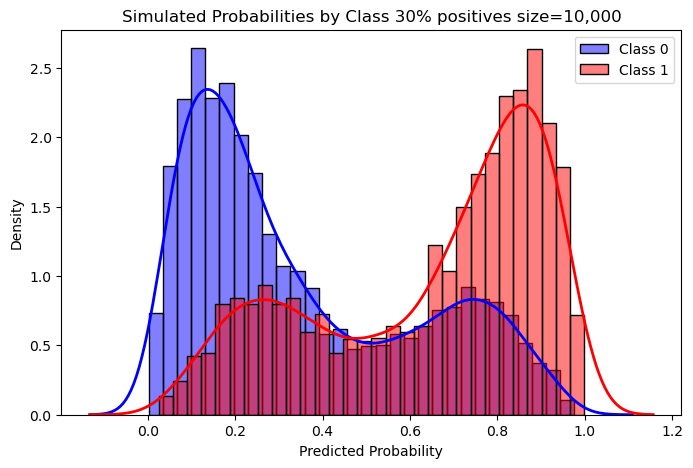


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5669,0.1928,0.7845,0.1357
Platt,0.4977,0.1646,0.7845,0.0332
Isotonic,0.4899,0.1622,0.7870,0.0000
Venn-Abers-IVAP,0.4909,0.1623,0.7868,0.0033



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5506,0.1844,0.8067,0.1434
Platt,0.4781,0.1565,0.8067,0.0214
Isotonic,0.4900,0.1568,0.8065,0.0242
Venn-Abers-IVAP,0.4794,0.1568,0.8067,0.0233


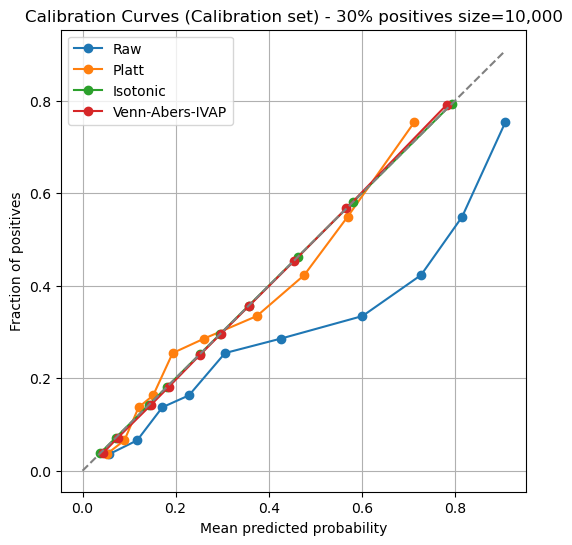

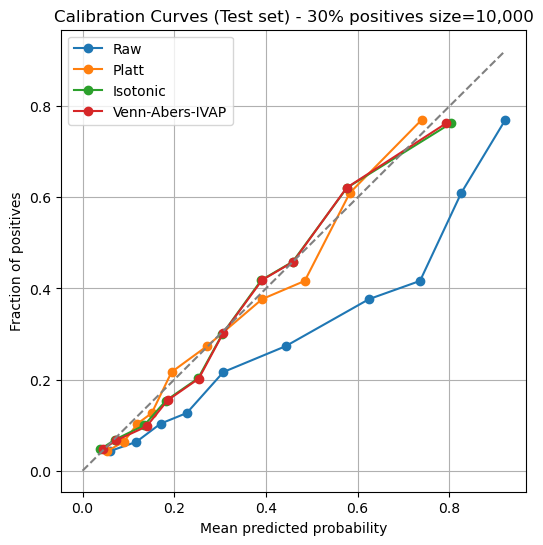

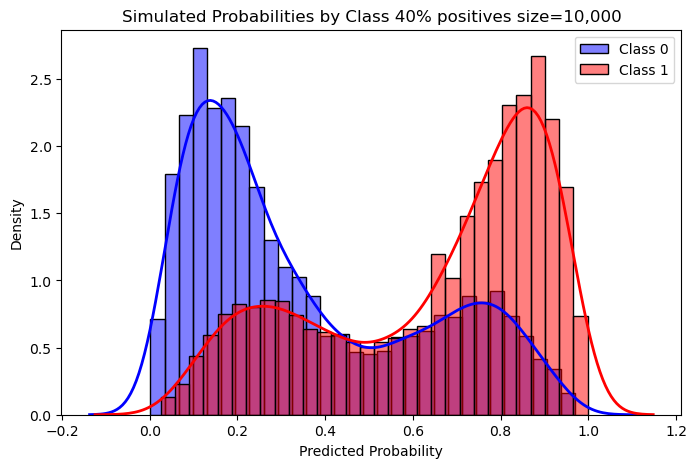


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5616,0.1903,0.7931,0.0706
Platt,0.5370,0.1807,0.7931,0.0288
Isotonic,0.5293,0.1782,0.7952,0.0000
Venn-Abers-IVAP,0.5303,0.1783,0.7951,0.0032



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5743,0.1947,0.7818,0.0754
Platt,0.5473,0.1845,0.7818,0.0164
Isotonic,0.5488,0.1847,0.7807,0.0118
Venn-Abers-IVAP,0.5487,0.1847,0.7809,0.0114


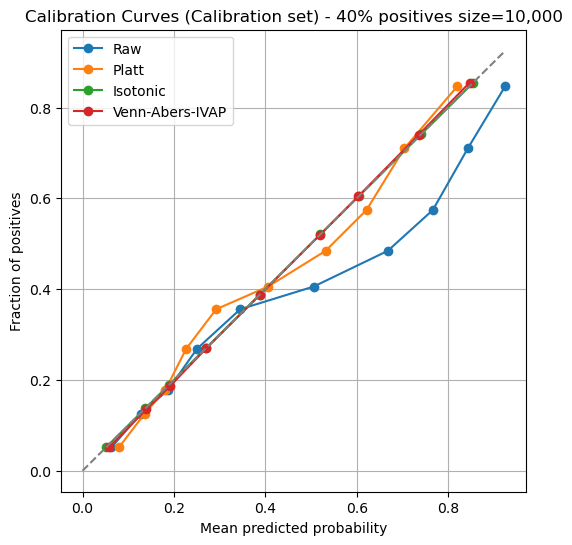

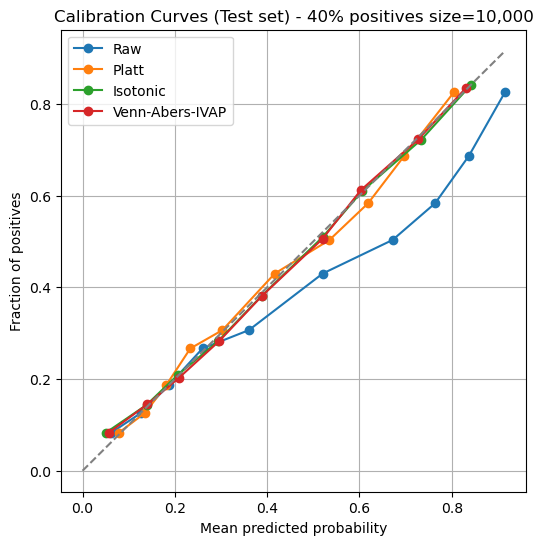

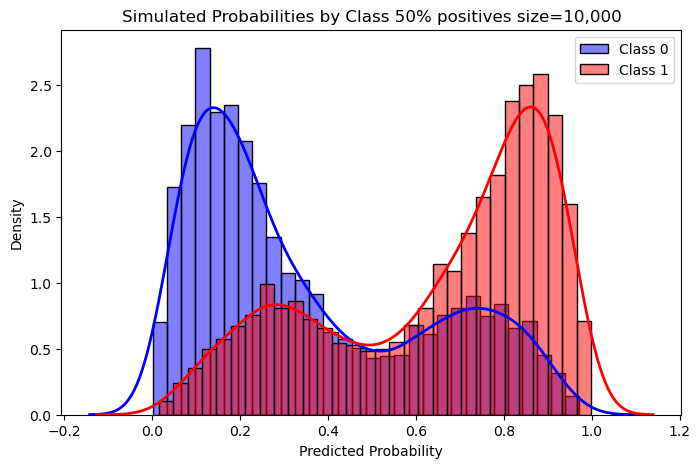


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5625,0.1899,0.7924,0.0566
Platt,0.5528,0.1866,0.7924,0.0226
Isotonic,0.5464,0.1843,0.7947,0.0000
Venn-Abers-IVAP,0.5472,0.1845,0.7945,0.0031



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5679,0.1921,0.7888,0.0633
Platt,0.5576,0.1886,0.7888,0.0308
Isotonic,0.5550,0.1875,0.7885,0.0203
Venn-Abers-IVAP,0.5547,0.1873,0.7885,0.0192


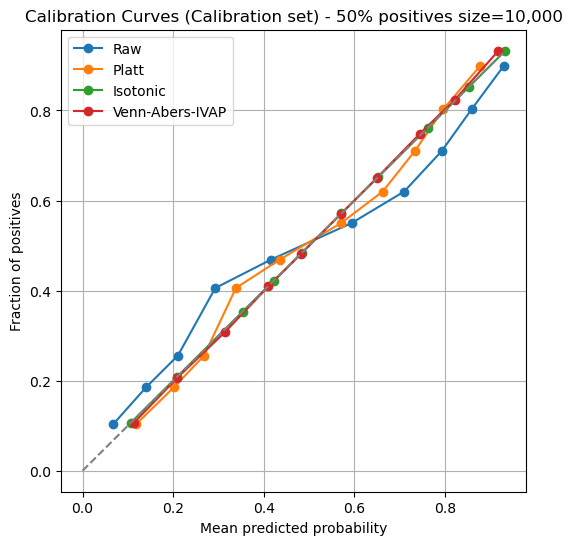

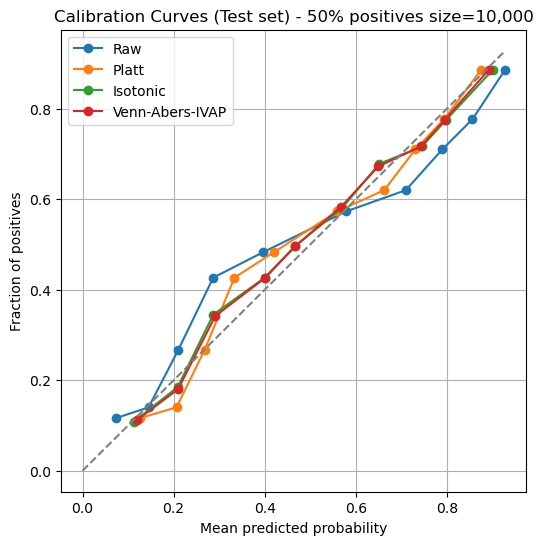

In [22]:
# Size of dataset: 10,000 samples
run_simulation({0: 9500, 1: 500}, title="5% positives size=10,000")

run_simulation({0: 9000, 1: 1000}, title="10% positives size=10,000")

run_simulation({0: 8000, 1: 2000}, title="20% positives size=10,000")

run_simulation({0: 7000, 1: 3000}, title="30% positives size=10,000")

run_simulation({0: 6000, 1: 4000}, title="40% positives size=10,000")

run_simulation({0: 5000, 1: 5000}, title="50% positives size=10,000")


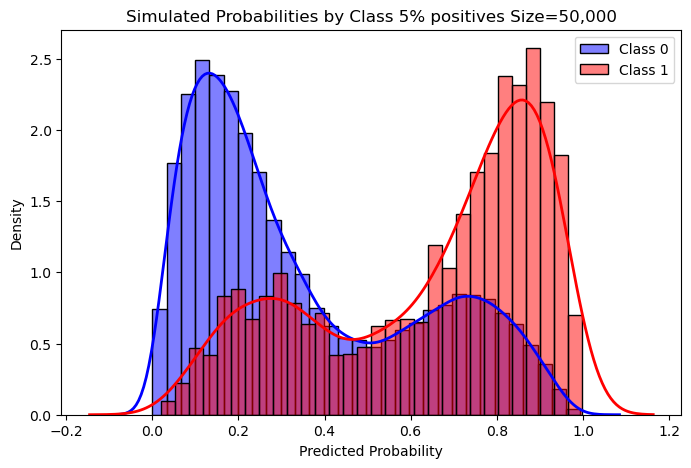


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5620,0.1899,0.7935,0.3144
Platt,0.1684,0.0433,0.7935,0.0046
Isotonic,0.1669,0.0430,0.7960,0.0000
Venn-Abers-IVAP,0.1671,0.0430,0.7958,0.0009



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5639,0.1911,0.7800,0.3135
Platt,0.1719,0.0439,0.7800,0.0055
Isotonic,0.1730,0.0438,0.7800,0.0042
Venn-Abers-IVAP,0.1710,0.0438,0.7796,0.0039


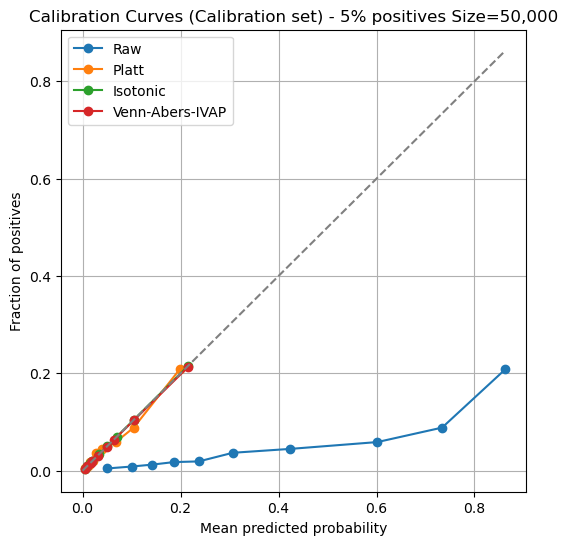

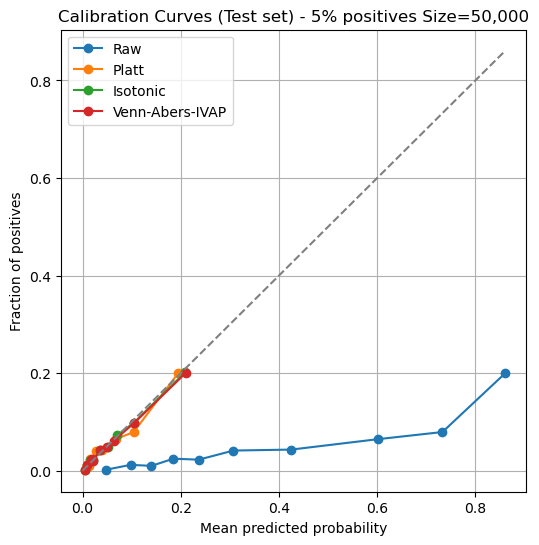

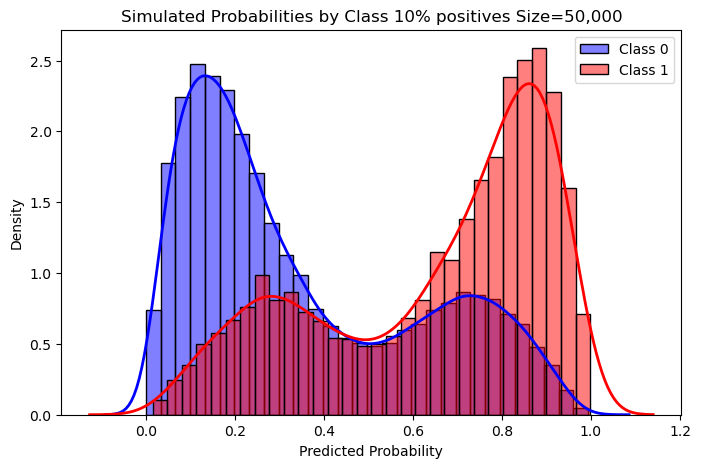


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5658,0.1914,0.7904,0.2805
Platt,0.2719,0.0781,0.7904,0.0120
Isotonic,0.2697,0.0776,0.7920,0.0000
Venn-Abers-IVAP,0.2699,0.0776,0.7919,0.0008



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5536,0.1872,0.7984,0.2767
Platt,0.2683,0.0772,0.7984,0.0136
Isotonic,0.2672,0.0770,0.7976,0.0060
Venn-Abers-IVAP,0.2673,0.0770,0.7978,0.0062


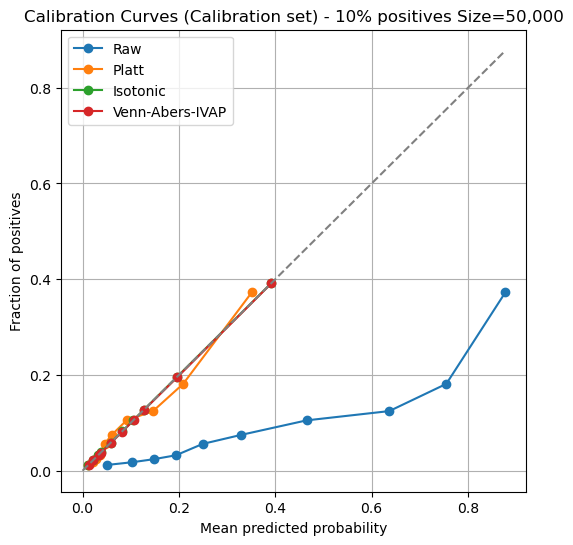

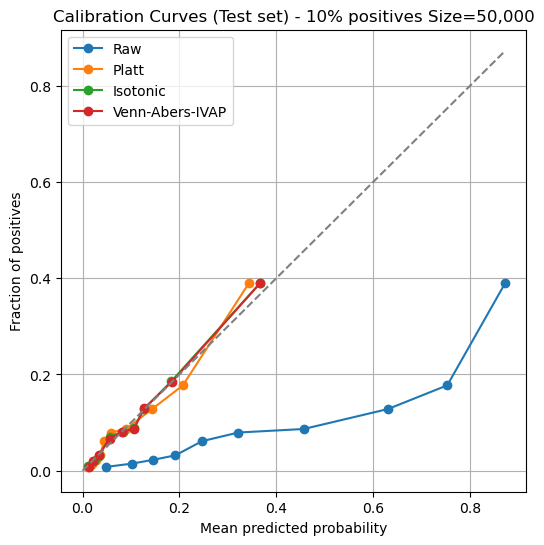

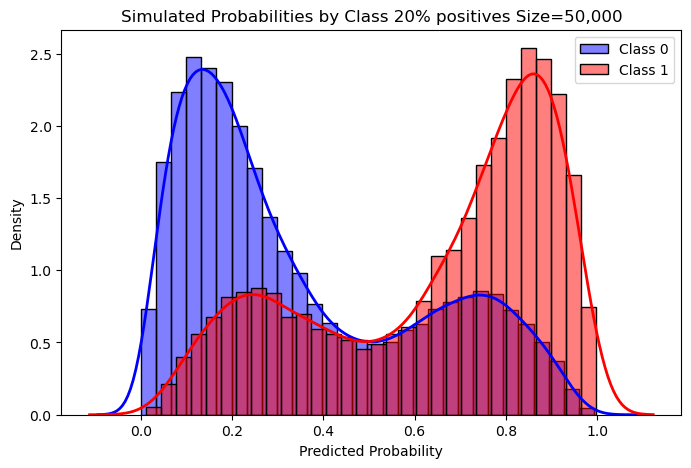


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5676,0.1921,0.7869,0.2104
Platt,0.4103,0.1294,0.7869,0.0157
Isotonic,0.4077,0.1285,0.7879,0.0000
Venn-Abers-IVAP,0.4078,0.1286,0.7879,0.0011



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5572,0.1881,0.7938,0.2067
Platt,0.4060,0.1285,0.7938,0.0142
Isotonic,0.4052,0.1283,0.7937,0.0080
Venn-Abers-IVAP,0.4054,0.1283,0.7937,0.0082


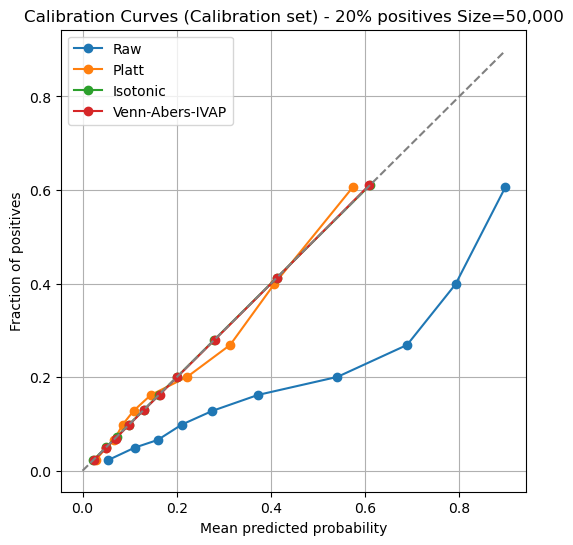

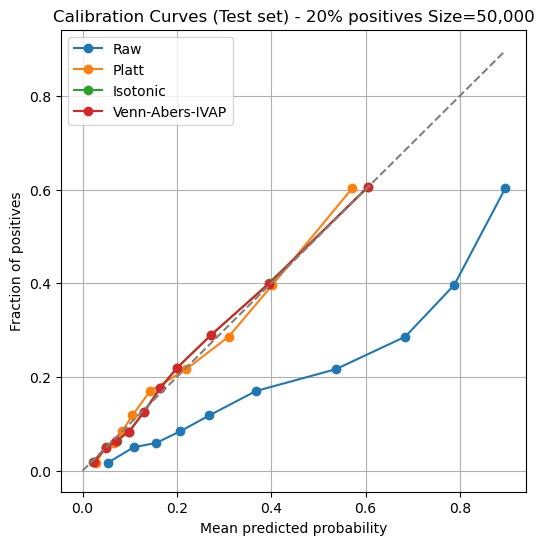

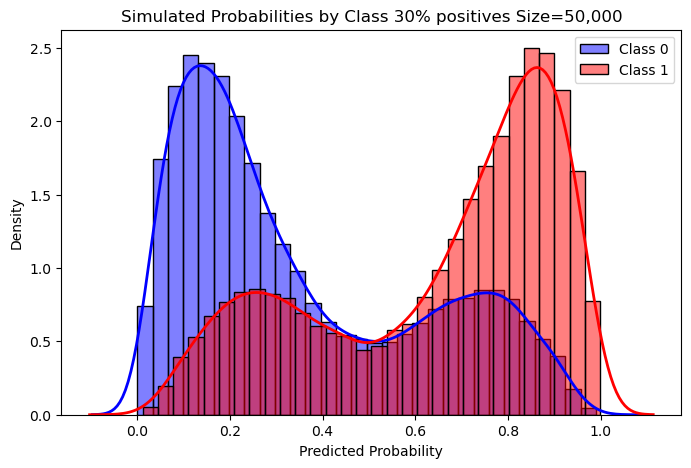


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5658,0.1917,0.7889,0.1398
Platt,0.4936,0.1627,0.7889,0.0220
Isotonic,0.4898,0.1615,0.7898,0.0000
Venn-Abers-IVAP,0.4901,0.1615,0.7898,0.0011



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5583,0.1886,0.7948,0.1390
Platt,0.4885,0.1608,0.7948,0.0172
Isotonic,0.4927,0.1608,0.7944,0.0114
Venn-Abers-IVAP,0.4884,0.1608,0.7945,0.0115


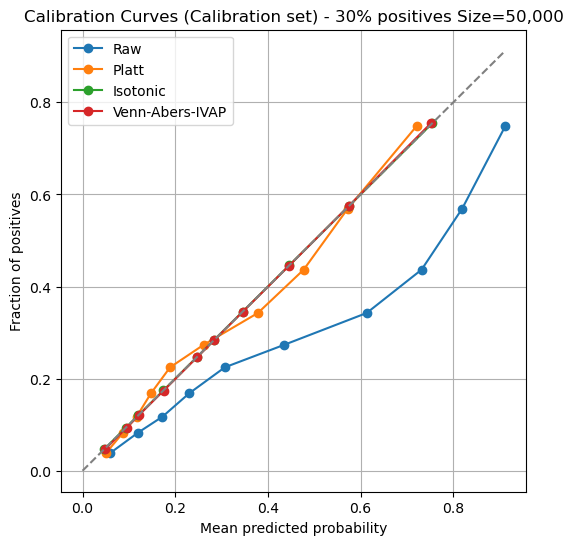

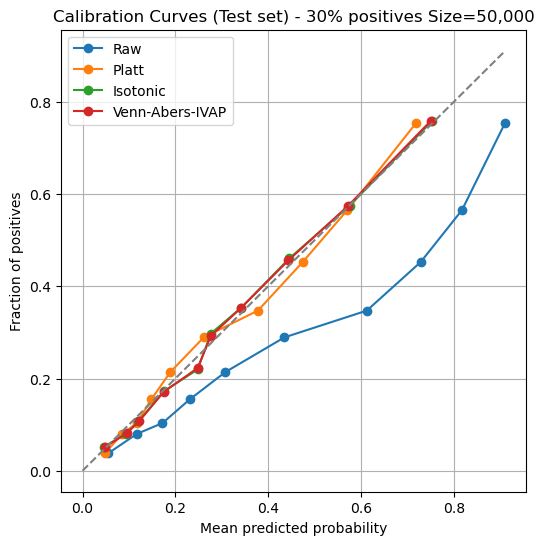

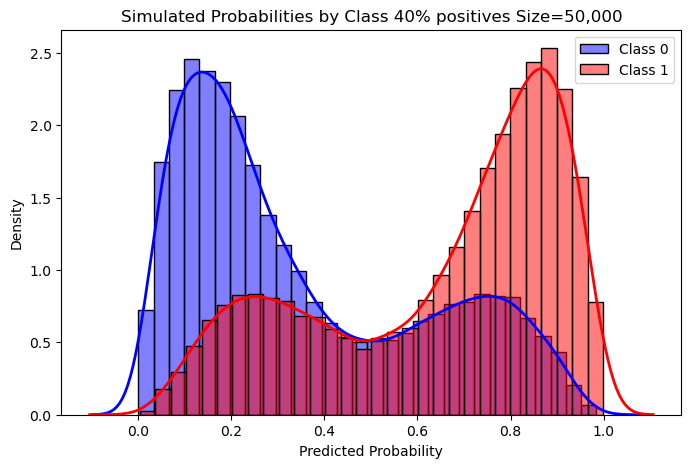


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5641,0.1910,0.7896,0.0711
Platt,0.5394,0.1815,0.7896,0.0196
Isotonic,0.5360,0.1803,0.7905,0.0000
Venn-Abers-IVAP,0.5362,0.1804,0.7905,0.0011



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5593,0.1890,0.7957,0.0729
Platt,0.5347,0.1795,0.7957,0.0255
Isotonic,0.5370,0.1787,0.7953,0.0132
Venn-Abers-IVAP,0.5329,0.1787,0.7953,0.0124


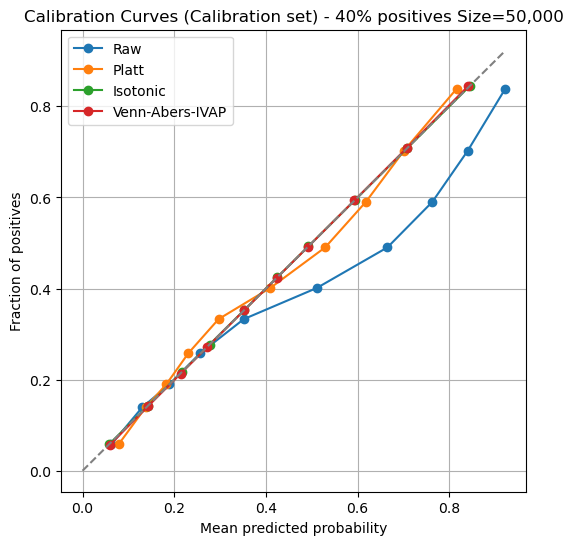

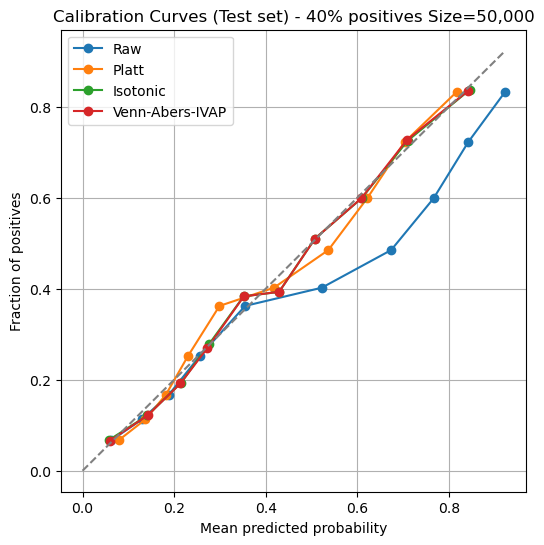

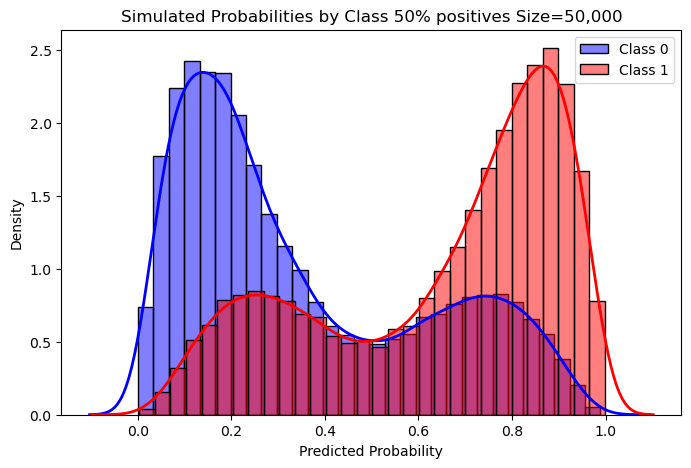


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5662,0.1917,0.7891,0.0579
Platt,0.5558,0.1881,0.7891,0.0202
Isotonic,0.5523,0.1868,0.7898,0.0000
Venn-Abers-IVAP,0.5524,0.1868,0.7898,0.0011



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.5592,0.1885,0.7941,0.0535
Platt,0.5502,0.1854,0.7941,0.0152
Isotonic,0.5522,0.1855,0.7936,0.0118
Venn-Abers-IVAP,0.5500,0.1854,0.7938,0.0121


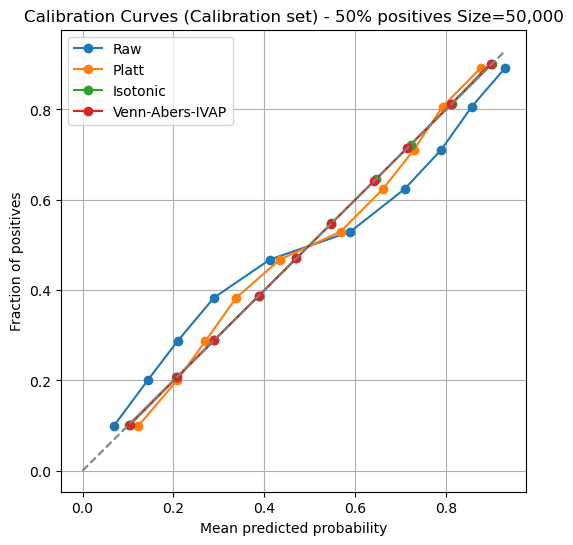

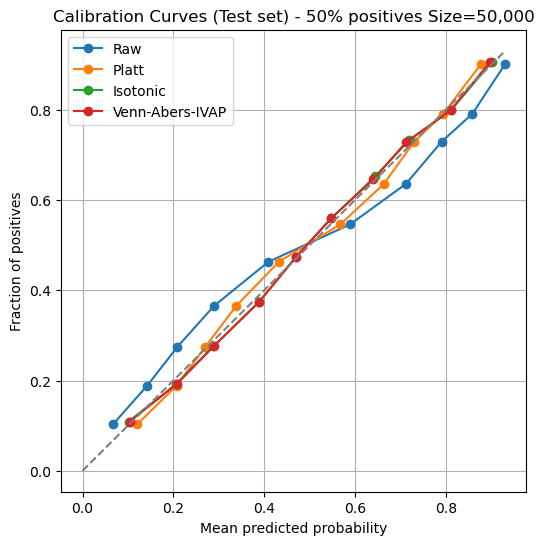

In [14]:
# Size of dataset: 50,000 samples
run_simulation({0: 47500, 1: 2500}, title="5% positives Size=50,000")

run_simulation({0: 45000, 1: 5000}, title="10% positives Size=50,000")

run_simulation({0: 40000, 1: 10000}, title="20% positives Size=50,000")

run_simulation({0: 35000, 1: 15000}, title="30% positives Size=50,000")

run_simulation({0: 30000, 1: 20000}, title="40% positives Size=50,000")

run_simulation({0: 25000, 1: 25000}, title="50% positives Size=50,000")